# Using HuggingFace and PyTorch Lightning for multi-label text classification - 01 - pre-processing

Revision: 1.00

Date: $20^{th}. May, 2021$

Author: Anshul Verma

PyTorch Lightning to Pytorch is like keras to tensorflow, and it makes job easy.

In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 2021
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
np.random.seed(RANDOM_SEED)

#### Mount the google drive and load the scraped data

we have a column called category in the  dataframe which is what we will consider to be the final class after removing the sub-categories for now.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%ls drive/MyDrive/arXiv/raw/

math_1991-08-14_None.csv     q-fin_1991-08-14_None.csv
physics_1991-08-14_None.csv  stat_1991-08-14_None.csv
q-bio_1991-08-14_None.csv


In [ ]:
import os 
import os.path as osp
root = 'drive/MyDrive/arXiv/raw/'
files = os.listdir(root)

df = None
for file in files:
  df_ = pd.read_csv(osp.join(root, file))
  if df is None:
    df = df_
  else:
    df = pd.concat([df, df_], axis=0, join="inner")

df_ = None
df.head()

,id,title,categories,abstract,doi,created,updated,authors
0,704.0002,sparsity-certifying graph decompositions,math.co cs.cg,"we describe a new algorithm, the $(k,\ell)$-pe...",NaN,2007-03-30,2008-12-13,"['ileana streinu', 'louis theran']"
1,704.0004,a determinant of stirling cycle numbers counts...,math.co,we show that a determinant of stirling cycle n...,NaN,2007-03-30,NaN,['david callan']
2,704.0005,from dyadic $\lambda_{\alpha}$ to $\lambda_{\a...,math.ca math.fa,in this paper we show how to compute the $\lam...,NaN,2007-04-02,NaN,"['wael abu-shammala', 'alberto torchinsky']"
3,704.0010,"partial cubes: structures, characterizations, ...",math.co,partial cubes are isometric subgraphs of hyper...,NaN,2007-03-31,NaN,['sergei ovchinnikov']
4,704.0011,computing genus 2 hilbert-siegel modular forms...,math.nt math.ag,in this paper we present an algorithm for comp...,NaN,2007-03-31,2008-08-20,"['clifton cunningham', 'lassina dembele']"


In [ ]:
print(f"Overall we have {len(df)} papers with their Title and the abstract. \n\n")

categories = [cat for cats in df['categories'].values.tolist() for cat in cats.split(' ')]

print(f"There are {len(np.unique(categories))} categories for records in the"\
      f"dataframe are {np.unique(categories)} papers with their Title and the"\
      "abstract")

Overall we have 40000 papers with their Title and the abstract. 


There are 154 categories for records in thedataframe are ['astro-ph' 'astro-ph.co' 'astro-ph.ep' 'astro-ph.ga' 'astro-ph.he'
 'astro-ph.im' 'astro-ph.sr' 'cond-mat.dis-nn' 'cond-mat.mes-hall'
 'cond-mat.mtrl-sci' 'cond-mat.other' 'cond-mat.quant-gas' 'cond-mat.soft'
 'cond-mat.stat-mech' 'cond-mat.str-el' 'cond-mat.supr-con' 'cs.ai'
 'cs.ar' 'cs.cc' 'cs.ce' 'cs.cg' 'cs.cl' 'cs.cr' 'cs.cv' 'cs.cy' 'cs.db'
 'cs.dc' 'cs.dl' 'cs.dm' 'cs.ds' 'cs.et' 'cs.fl' 'cs.gl' 'cs.gr' 'cs.gt'
 'cs.hc' 'cs.ir' 'cs.it' 'cs.lg' 'cs.lo' 'cs.ma' 'cs.mm' 'cs.ms' 'cs.na'
 'cs.ne' 'cs.ni' 'cs.oh' 'cs.pf' 'cs.pl' 'cs.ro' 'cs.sc' 'cs.sd' 'cs.se'
 'cs.si' 'cs.sy' 'econ.em' 'econ.gn' 'econ.th' 'eess.iv' 'eess.sp'
 'eess.sy' 'gr-qc' 'hep-ex' 'hep-lat' 'hep-ph' 'hep-th' 'math-ph'
 'math.ac' 'math.ag' 'math.ap' 'math.at' 'math.ca' 'math.co' 'math.ct'
 'math.cv' 'math.dg' 'math.ds' 'math.fa' 'math.gm' 'math.gn' 'math.gr'
 'math.gt' 'math.ho' 'math.it' 

### We can see that the categories have sub-divisions mentioned for the purpose of this problem we will use only the category and not the sub-category

Lets create a column for `topics` of these papers which is more broad than `categories`

In [ ]:
categories = [cats.split(' ') for cats in df['categories'].values.tolist()]
topics = []
for cats_ in categories:
  topics_for_id = []
  for cat in cats_:
    if cat.split('.')[0] not in topics_for_id:
      topics_for_id.append(cat.split('.')[0])
  topics.append(topics_for_id)

df['topics'] = topics
df.head()

,id,title,categories,abstract,doi,created,updated,authors,topics
0,704.0002,sparsity-certifying graph decompositions,math.co cs.cg,"we describe a new algorithm, the $(k,\ell)$-pe...",NaN,2007-03-30,2008-12-13,"['ileana streinu', 'louis theran']","[math, cs]"
1,704.0004,a determinant of stirling cycle numbers counts...,math.co,we show that a determinant of stirling cycle n...,NaN,2007-03-30,NaN,['david callan'],[math]
2,704.0005,from dyadic $\lambda_{\alpha}$ to $\lambda_{\a...,math.ca math.fa,in this paper we show how to compute the $\lam...,NaN,2007-04-02,NaN,"['wael abu-shammala', 'alberto torchinsky']",[math]
3,704.0010,"partial cubes: structures, characterizations, ...",math.co,partial cubes are isometric subgraphs of hyper...,NaN,2007-03-31,NaN,['sergei ovchinnikov'],[math]
4,704.0011,computing genus 2 hilbert-siegel modular forms...,math.nt math.ag,in this paper we present an algorithm for comp...,NaN,2007-03-31,2008-08-20,"['clifton cunningham', 'lassina dembele']",[math]


#### Its evidently visible that one paper can be related to more than one topic lets visualize this overlap amoung these topics

## Class Distribution

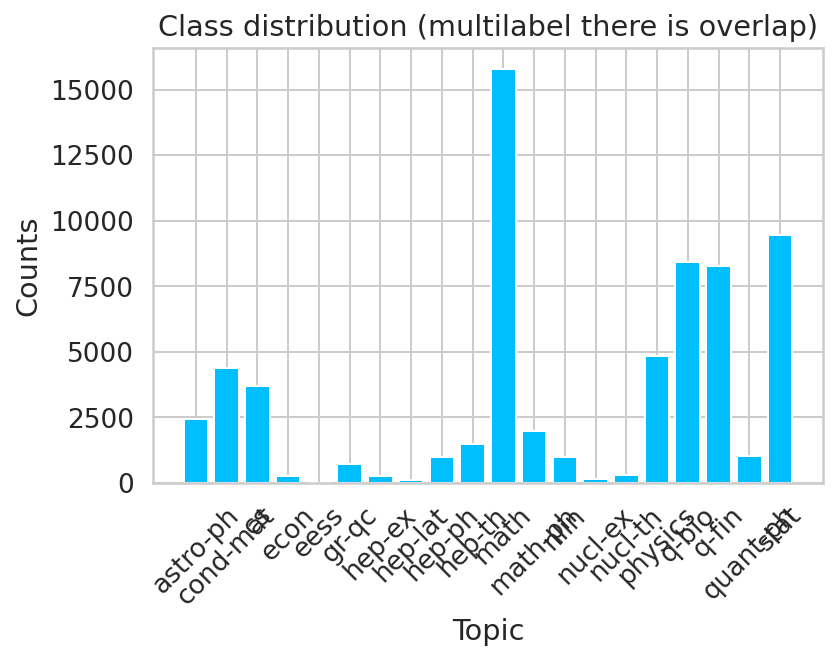

In [ ]:
uq_topics, counts = np.unique([topic for topics_ in topics for topic in topics_],
                              return_counts=True)

plt.bar(range(len(uq_topics)), counts)
plt.xticks(ticks=range(len(uq_topics)), labels=uq_topics, rotation=45)
plt.ylabel('Counts')
plt.xlabel('Topic')
plt.title('Class distribution (multilabel there is overlap)')
plt.show()

We can see that there are a lot of classes with few counts which means that the class distribution is highly imbalance so lets not keep all the topics lets just the major topics like,

`math`, `stat`, `physics`, `q-bio` and `q-fin`

#### Updating the column topics of the data-frame to keep only the major classes

In [ ]:
major_topics = ['math', 'stat', 'physics', 'q-bio', 'q-fin']
major_topics_ = []
for topics_ in topics:
  major_topics_per_paper = []
  for topic in topics_:
    if topic in major_topics:
      major_topics_per_paper.append(topic)
  major_topics_.append(major_topics_per_paper)

df['major_topics'] = major_topics_
df.head()

,id,title,categories,abstract,doi,created,updated,authors,topics,major_topics
0,704.0002,sparsity-certifying graph decompositions,math.co cs.cg,"we describe a new algorithm, the $(k,\ell)$-pe...",NaN,2007-03-30,2008-12-13,"['ileana streinu', 'louis theran']","[math, cs]",[math]
1,704.0004,a determinant of stirling cycle numbers counts...,math.co,we show that a determinant of stirling cycle n...,NaN,2007-03-30,NaN,['david callan'],[math],[math]
2,704.0005,from dyadic $\lambda_{\alpha}$ to $\lambda_{\a...,math.ca math.fa,in this paper we show how to compute the $\lam...,NaN,2007-04-02,NaN,"['wael abu-shammala', 'alberto torchinsky']",[math],[math]
3,704.0010,"partial cubes: structures, characterizations, ...",math.co,partial cubes are isometric subgraphs of hyper...,NaN,2007-03-31,NaN,['sergei ovchinnikov'],[math],[math]
4,704.0011,computing genus 2 hilbert-siegel modular forms...,math.nt math.ag,in this paper we present an algorithm for comp...,NaN,2007-03-31,2008-08-20,"['clifton cunningham', 'lassina dembele']",[math],[math]


In [ ]:
print(f"Number of paper missing the major topics are"\
      f" {len([1 for chk in df['major_topics'].values.tolist() if len(chk)==0])}")

Number of paper missing the major topics are 6589


There are some subdivision of physics toips which do not have major_topic as physics. Lets address that by topic having `['astro-ph', 'cond-mat', 'gr-qc', 'hep-ex', 'hep-lat', 'hep-ph', 'hep-th',  'nucl-ex', 'nucl-th', 'quant-ph']` are added to major topic `physics` as they are subdivisions of `physics`, whereas `['cs', 'nlin']` are being added to `math`. This is only if they(the paper) does not have a major category.

In [ ]:
physics_subdivsions = ['astro-ph', 'cond-mat', 'gr-qc', 'hep-ex', 'hep-lat', 'hep-ph', 'hep-th', 'nucl-ex', 'nucl-th', 'quant-ph']
math_subdivisons = ['cs', 'nlin']

major_topics_ = []
for topic, m_topic in zip(df['topics'].values.tolist(),
                          df['major_topics'].values.tolist()):
  if len(m_topic) == 0:
    new_m_topics = []
    for topic_ in topic:
      if topic_ in physics_subdivsions:
        if 'physics' not in new_m_topics:
          new_m_topics.append('physics')
      if topic_ in math_subdivisons:
        if 'math' not in new_m_topics:
          new_m_topics.append('math')
    major_topics_.append(new_m_topics)
  else:
    major_topics_.append(m_topic)

df['major_topics'] = major_topics_

Ensuring that there is no row with no major-topic

In [ ]:
print(f"Number of paper missing the major topics are"\
      f" {len([1 for chk in df['major_topics'].values.tolist() if len(chk)==0])}")

Number of paper missing the major topics are 0


#### Checking the data distribution amonf the major classes now

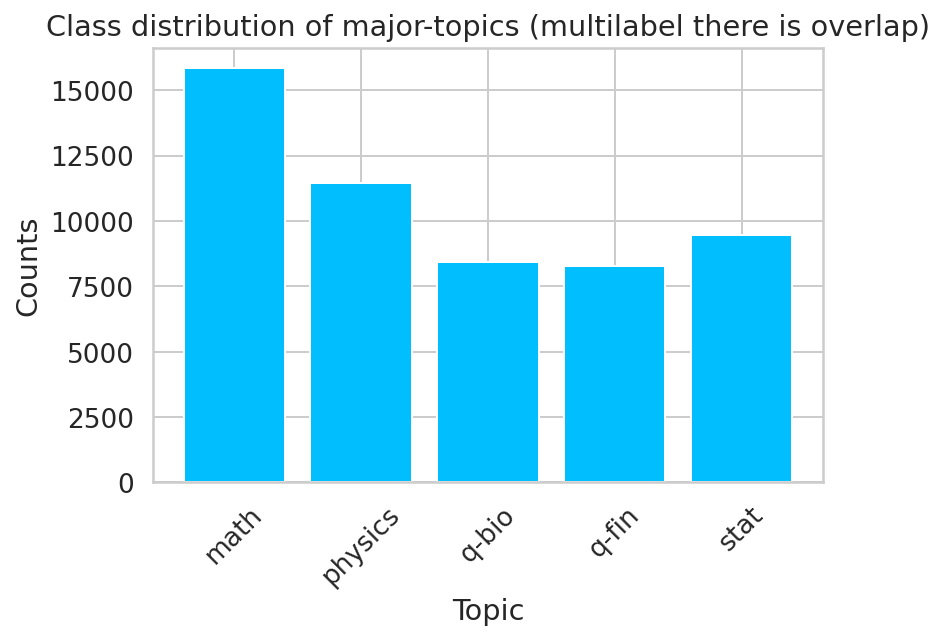

In [ ]:
uq_topics, counts = np.unique([topic for topics_ in major_topics_ for topic in topics_],
                              return_counts=True)

plt.bar(range(len(uq_topics)), counts)
plt.xticks(ticks=range(len(uq_topics)), labels=uq_topics, rotation=45)
plt.ylabel('Counts')
plt.xlabel('Topic')
plt.title('Class distribution of major-topics (multilabel there is overlap)')
plt.show()

#### This seems more reasonable a spread and we can now try and transfer the BERT model to classify these classes but before we move ahead we should try and visualize the overlap between these classes

There are a lot of ways in which we can visualize this overlap amongst the classes but lets try and keep it simple.

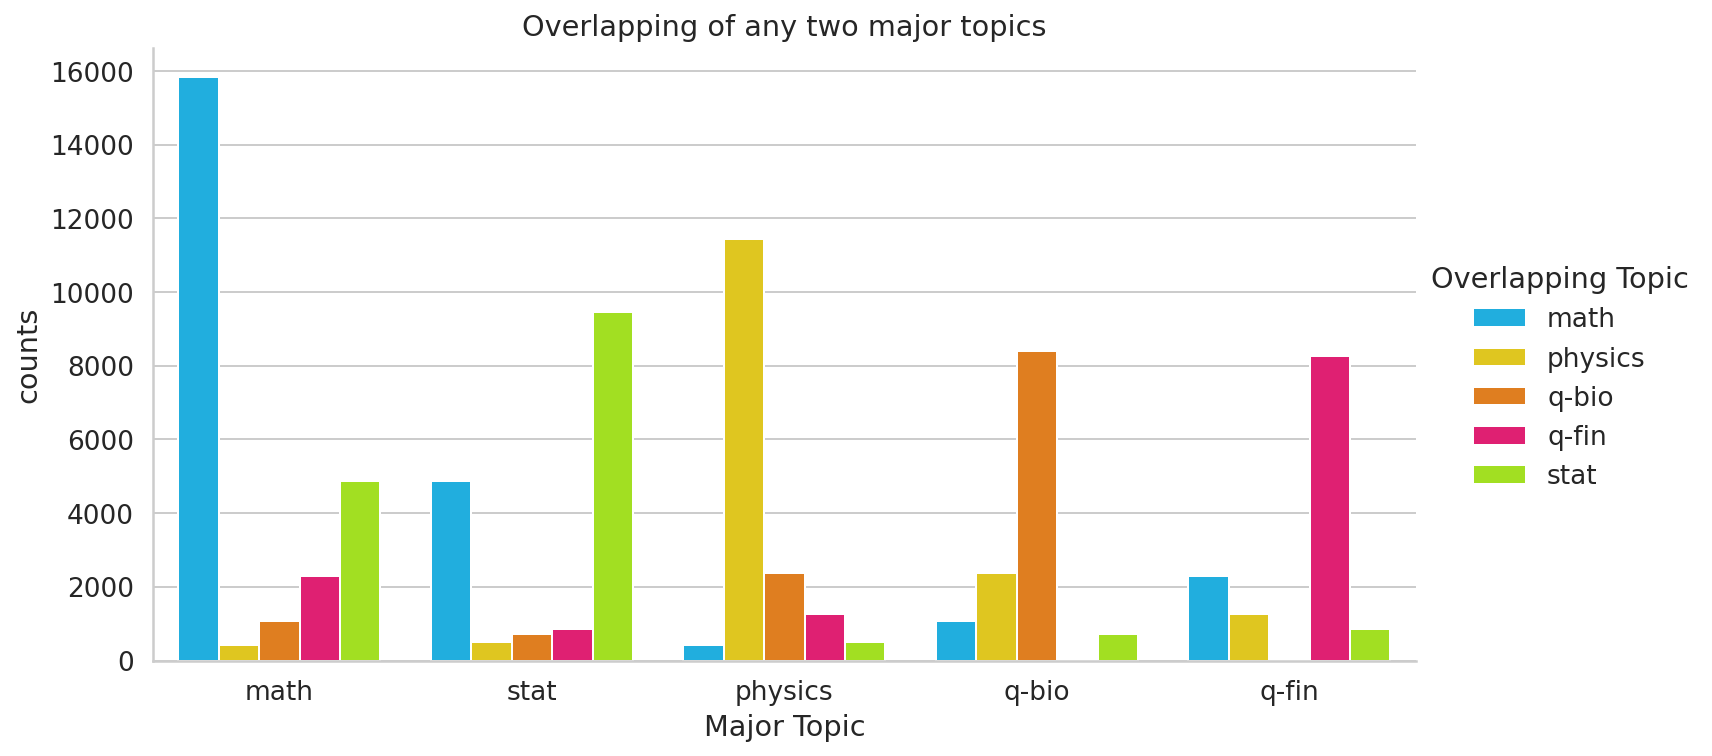

In [ ]:
df_dummy = pd.DataFrame()
major_topics_dummy = []
overlap_topics_dummy = []
overlap_counts_dummy = []
for topic in major_topics:
  major_topics_w_topic = []
  for topics_per_paper in major_topics_:
    if topic in topics_per_paper:
      for topic_ in topics_per_paper:
        major_topics_w_topic.append(topic_)
  topic_dummy, counts_dummy = np.unique(major_topics_w_topic, return_counts=True)
  major_topics_dummy += [topic for _ in topic_dummy]
  overlap_topics_dummy += [topic__ for topic__ in topic_dummy]
  overlap_counts_dummy += [counts__ for counts__ in counts_dummy]
  
df_dummy['Major Topic'] = major_topics_dummy
df_dummy['Overlapping Topic'] = overlap_topics_dummy
df_dummy['counts'] = overlap_counts_dummy

sns.catplot(x="Major Topic", y="counts",
            hue="Overlapping Topic", 
            data=df_dummy, kind="bar", 
            height=5, aspect=10/5)
plt.title("Overlapping of any two major topics")
plt.show()

It is evidently visible that there is significant overlap between `stat` and `math` which is very much expected and there is sone overlap `physics` and `q-bio`. Again this is just visualizing the overlap of any two classes there are better ways to visualize the overlap across all the other classes as well. I will exploit it later as that's not of interest right now.

#### Let's move towards model-building lets start by dropping all the columns that we do not need (`topics`, `authors`, `updated`, `created`, `doi`, `categories`) and one hot encode out final classification columns.

In [ ]:
# Dropping the unwanted columnss
df.drop(['topics', 'authors', 'updated', 'created', 'doi', 'categories'], axis=1, inplace=True)
# Encoding the labels
final_label = df['major_topics'].str.join(sep='*').str.get_dummies(sep='*')
# Drop column major_topics as it is now encoded
frames = [df, final_label]
df = pd.concat(frames, axis=1)
# Join the encoded labels
df.drop('major_topics', axis=1, inplace=True)
df.head()

,id,title,abstract,math,physics,q-bio,q-fin,stat
0,704.0002,sparsity-certifying graph decompositions,"we describe a new algorithm, the $(k,\ell)$-pe...",1,0,0,0,0
1,704.0004,a determinant of stirling cycle numbers counts...,we show that a determinant of stirling cycle n...,1,0,0,0,0
2,704.0005,from dyadic $\lambda_{\alpha}$ to $\lambda_{\a...,in this paper we show how to compute the $\lam...,1,0,0,0,0
3,704.0010,"partial cubes: structures, characterizations, ...",partial cubes are isometric subgraphs of hyper...,1,0,0,0,0
4,704.0011,computing genus 2 hilbert-siegel modular forms...,in this paper we present an algorithm for comp...,1,0,0,0,0


#### Saving the final dataframe

In [ ]:
df.to_csv('drive/MyDrive/arXiv/final_df.csv', index=False)

This dataframe can now be used for experiments. Lets just analyse it a bit more to get the lengt of title and abstract so that this info can be used in the models.

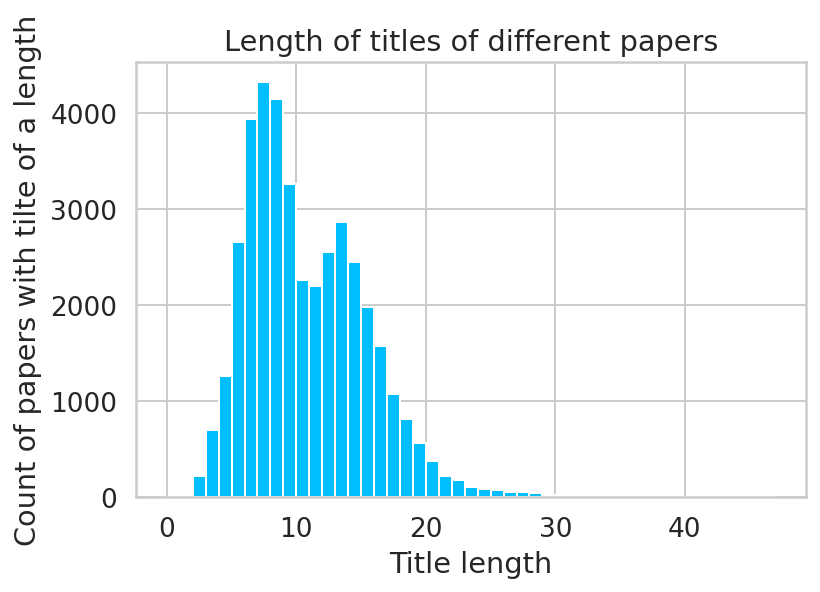

In [ ]:
title_length = [len(title.split(' ')) for title in df['title'].values.tolist()]
plt.hist(title_length, bins=max(title_length), range=(0, max(title_length)))
plt.ylabel('Count of papers with tilte of a length')
plt.xlabel('Title length')
plt.title('Length of titles of different papers')
plt.show()                    

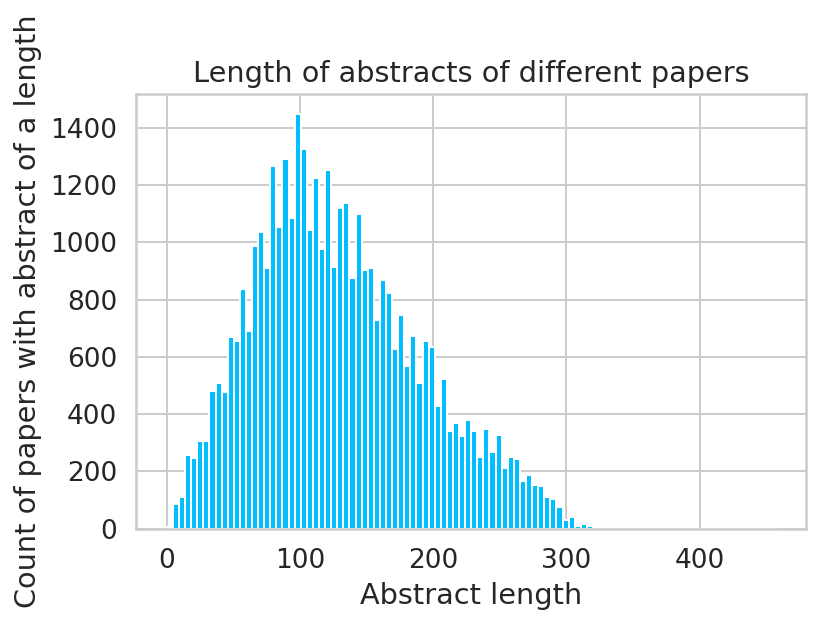

In [ ]:
abstract_length = [len(abstract.split(' ')) for abstract in df['abstract'].values.tolist()]
plt.hist(title_abstract, bins=100, range=(0, max(abstract_length)))
plt.ylabel('Count of papers with abstract of a length')
plt.xlabel('Abstract length')
plt.title('Length of abstracts of different papers')
plt.show()      

There for a model to classify based on just the titles of the papers a encoding length of `24-30` should be enough. 

Whereas to train a model on the abstracts the encoder length of `256-312` should be ideal.